# Malware detection from PCAP Network Captures

> This is a project to detect malware from PCAP network captures. 

In [2]:
#| default_exp core

In [3]:
#| hide
from nbdev.showdoc import *

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
#| export 

import pandas as pd
import numpy as np
from pathlib import Path
from typing import List, Dict, Any, Optional, Union

import ipaddress
from collections import OrderedDict
from datetime import datetime

import netaddr
import numpy as np
import pandas as pd
#from scapy.layers.inet import IP, TCP, UDP, ICMP
from scapy.all import *

## Processing PCAP files

The first step is to process the PCAP files and extract the features. The main library I am using for this is scapy, but I am going to create some helper functions to make it easier to extract the features I want. 


In [53]:

#| export 

def _get_fid(pkt):
    """Extract fid (five-tuple) from a packet: only focus on IPv4
    Parameters
    ----------

    Returns
    -------
        fid: five-tuple (IP src, IP dst, src port, dst port, protocol)
    """

    if IP in pkt and TCP in pkt:
        fid = (pkt[IP].src, pkt[IP].dst, pkt[TCP].sport, pkt[TCP].dport, 'TCP')
    elif IP in pkt and UDP in pkt:
        fid = (pkt[IP].src, pkt[IP].dst, pkt[UDP].sport, pkt[UDP].dport, 'UDP')
    else:  # others
        fid = ('', '', -1, -1, "UNK")

    return fid

def _get_frame_time(pkt):
    return float(pkt.time)

def flow_duration(pkts: List) -> float:
    pkt_times = [float(pkt.time) for pkt in pkts]
    flow_duration = max(pkt_times) - min(pkt_times)
    return flow_duration
    


In [80]:

class PacketFlows:
    
    def __init__(self, 
                 pcap_file: Path or str, 
                 interval: float = 0, 
                 q_interval: float = 0.90,
                 min_pkts: int = 2, 
                 tcp_timeout: int = 600, 
                 udp_timeout: int = 600, 
                 verbose: int = 0):
        """
        Parameters
        ----------
        pcap: Path or str
            a pcap needed to processed.

        min_pkts: int (default is 2)
            the minimum number of packets of each flow is to control which flow should be kept
            and which one should be discarded. The default value is 2, i.e., all the flows which have less than 2 packets
            are discarded. It must be >= 2.

        tcp_timeout: int (default is 600s)
            a timeout is to split flow

        ucp_timeout: int (default is 600s)
            a timeout is to split flow

        verbose: int (default is 1)
            a print level is to control what information should be printed according to the given value.
            The higher the value is, the more info is printed.

        """

        
        self.min_pkts = min_pkts
        self.tcp_timeout = tcp_timeout
        self.udp_timeout = udp_timeout
        self.verbose = verbose
        self.pcap_file = str(pcap_file)
        
        # Seperate into seperate flows, not segmented by time
        full_flow = self._pcap2flows(verbose=verbose)
        self.interval = self._fetch_interval(full_flow, interval, q_interval)
        # Seperate into flows segmented by time, using the interval as the time segment
        self.flows = self.flows2subflows(full_flow, self.interval)
        
    def _fetch_interval(self, 
                        fflow: OrderedDict,
                        interval: float, 
                        q_interval: float) -> float:
        if interval > 0:
            return interval
        else:
            if q_interval > 0:
                self.flow_durations = [flow_duration(pkts) for fid, pkts in fflow]
                self.interval = self.split_interval(self.flow_durations, q_interval=q_interval)
                return self.interval
            else:
                msg = f'q_interval must be in [0, 1]! Current q_interval is {q_interval}.'
                raise ValueError(msg)
            
    def split_interval(self, flow_durations, q_interval=0.9):
        interval = np.quantile(flow_durations, q=q_interval)
        return interval
        
    def __getitem__(self, index:int):
        return self.flows[index] 
    
    def __len__(self):
        return len(self.flows)   
    
    def __iter__(self):
        return iter(self.flows)

    def summary(self):
        print(f'pcap_file: {self.pcap_file}')
        print("Number of flows: ", len(self.flows))
        print("Number of packets: ", [len(v[1]) for v in self.flows])
        
    @property
    def src_ports(self) -> np.array:
        return np.array([flow[0][2] for flow in self.flows])
        
    @property
    def dst_ports(self) -> np.array:
        return np.array([flow[0][3] for flow in self.flows])
        
    @property
    def protocols(self) -> np.array:
        return np.array([str(flow[0][4]) for flow in self.flows])

    def _pcap2flows(self, verbose: int = 0) -> OrderedDict:
        
        if verbose:
            print(f'pcap_file: {self.pcap_file}')

        # store all extracted flows into a dictionary, whose key is flow id ('fid': five-tuple) and value is packtes
        # that belongs to the flow.
        flows = OrderedDict()
        try:
            # iteratively get each packet from the pcap
            for i, pkt in enumerate(PcapReader(self.pcap_file)):
                if (TCP in pkt) or (UDP in pkt):

                    # this function treats bidirection flows as two sessions (hereafter, we use sessions
                    # and flows interchangeably).
                    fid = _get_fid(pkt)

                    if fid not in flows.keys():
                        flows[fid] = [pkt]
                    else:
                        flows[fid].append(pkt)
                else:
                    continue

        except Exception as e:
            msg = f'Parse PCAP error: {e}!'
            raise RuntimeError(msg)

        if verbose > 3:
            print(f'len(flows): {len(flows.keys())}')

        # split flows by TIMEOUT and discard flows that have less than "flow_pkts_thres" packets.
        n_pkts = 0
        new_flows = []  # store the preprocessed flows
        for i, (fid, pkts) in enumerate(flows.items()):
            n_pkts += len(pkts)
            if len(pkts) < max(2, self.min_pkts):
                # discard flows that have less than "max(2, flow_pkts_thres)" packets
                continue

            # Is it necessary to sort packets by arrival_times?
            pkts = sorted(pkts, key=_get_frame_time, reverse=False)

            subflows = []
            # split flows by TIMEOUT
            for j, pkt in enumerate(pkts):
                pkt_time = _get_frame_time(pkt)
                if j == 0:
                    subflow_tmp = [pkt]
                    split_flow = False  # if a flow is not split with interval, label it as False, otherwise, True
                    continue
                # print(fid, pkt)
                if ('TCP' in fid) or (TCP in pkt):
                    # handle TCP packets, TCP is 6
                    # a timeout (the idle time) is the duration between the previous pkt and the current one.
                    if pkt_time - _get_frame_time(subflow_tmp[-1]) > self.tcp_timeout:
                        # Note: here subflow_tmp will only have 1 packet
                        subflows.append((fid, subflow_tmp))
                        subflow_tmp = [pkt]  # create a new subflow and store the current packet as the first packet of it.
                        split_flow = True
                    else:
                        subflow_tmp.append(pkt)
                elif ('UDP' in fid) or UDP in pkt:
                    # handle UDP packets, UDP is 17
                    if pkt_time - _get_frame_time(subflow_tmp[-1]) > self.udp_timeout:
                        subflows.append((fid, subflow_tmp))
                        subflow_tmp = [pkt]
                        split_flow = True
                    else:
                        subflow_tmp.append(pkt)
                else:  # other protocols
                    pass

            # if the current flow is not split by TIMEOUT, then add it into subflows
            if not split_flow:
                subflows.append((fid, subflow_tmp))
            else:
                pass # discard the last subflow_tmp

            new_flows.extend(subflows)

        new_flows = [(fid, pkts) for (fid, pkts) in new_flows if len(pkts) >= self.min_pkts]
        if verbose > 3:
            n_lt_2 = len([len(pkts) for fid, pkts in flows.items() if len(pkts) < self.min_pkts])
            n_gt_2 = len([len(pkts) for fid, pkts in flows.items() if len(pkts) >= self.min_pkts])
            print(f'total number of flows: {len(flows)}. Num of flows < {self.min_pkts} pkts: {n_lt_2}, '
                f'and >={self.min_pkts} pkts: {n_gt_2} without timeout splitting.')
            print(
                f'kept flows: {len(new_flows)}. Each of them has at least {self.min_pkts} pkts after timeout splitting.')

        return new_flows


    def flows2subflows(self, 
                       full_flow: OrderedDict, 
                       interval: float,
                       ) -> List:
        """Split flows to subflows by interval

        Returns
        -------
        subflows: list
            each of subflow has at least "flow_ptks_thres" packets
        """

        new_flows = []  # store all subflows
        for i, (fid, pkts) in enumerate(full_flow):
            if (self.verbose > 3) and (i % 1000) == 0:
                print(f'{i}th_flow: len(pkts): {len(pkts)}')

            # Is it necessary to sort packets by arrival_times ?
            pkts = sorted(pkts, key=_get_frame_time, reverse=False)

            subflows = []
            # split flows by interval
            for j, pkt in enumerate(pkts):
                pkt_time = _get_frame_time(pkt)
                if j == 0:
                    subflow_tmp_start_time = pkt_time
                    subflow_tmp = [(subflow_tmp_start_time, pkt)]
                    split_flow = False  # if a flow is not split with interval, label it as False, otherwise, True
                    continue

                if ('TCP' in fid) or (TCP in pkt):
                    # handle TCP packets, TCP is 6
                    # a timeout (the idle time) is the duration between the previous pkt and the current one.
                    if pkt_time - subflow_tmp[-1][0] > interval:
                        subflows.append((fid, subflow_tmp))
                        subflow_tmp_start_time += int((pkt_time - subflow_tmp_start_time) // interval) * interval
                        # create a new subflow and store "subflow_tmp_start_time" as the time. Here, it will has a tiny
                        # difference of packet time between "subflow_tmp_start_time" and the current packet time.
                        subflow_tmp = [(subflow_tmp_start_time, pkt)]
                        split_flow = True
                    else:
                        subflow_tmp.append((pkt_time, pkt))

                elif ('UDP' in fid) or UDP in pkt:
                    # handle UDP packets, UDP is 17
                    if pkt_time - subflow_tmp[-1][0] > interval:
                        subflows.append((fid, subflow_tmp))
                        subflow_tmp_start_time += int((pkt_time - subflow_tmp_start_time) // interval) * interval
                        subflow_tmp = [(subflow_tmp_start_time, pkt)]
                        split_flow = True
                    else:
                        subflow_tmp.append((pkt_time, pkt))
                else:  # it's not possible, because flows only include TCP and UDP flows
                    pass

            # if the current flow is not split by interval, then add it into subflows
            if not split_flow:
                subflows.append([fid, subflow_tmp])
            else:
                # discard the last subflow_tmp
                pass

            new_flows.extend(subflows)

        # sort all flows by packet arrival time, each flow must have at least two packets
        subflows = []
        for fid, subflow_tmp in new_flows:
            if len(subflow_tmp) < max(2, self.min_pkts):
                continue
            subflows.append((fid, [pkt for pkt_time, pkt in subflow_tmp]))

        new_flows = subflows
        if self.verbose > 1:
            print(f'After splitting flows, the number of subflows: {len(new_flows)} and each of them has at least '
                f'{self.min_pkts} packets.')

        return new_flows
    
    def apply_to_flows(self, func) -> np.array:
        return np.array(map(func, self.flows))
    
    
    @staticmethod 
    def iter_pcap_dict(pcap_file: str) -> Iterator:
        """Stream extracted dict mappings from PCAP file.

        Requires:
          self.pcap_file: string filepath of PCAP file

        Returns:
          Iterator of dicts with one dict per packet in pcap file.

            The dicts have the following key/value pairs:

              "time"      : time the packet was receieved in seconds since epoch
              "datetime"  : time the packet was received as a datetime object
              "length"    : length of packet in bytes
              "mac_src"   : source MAC address
              "mac_dst"   : destination MAC address
              "ip_src"    : source IP address
              "ip_dst"    : destination IP address
              "protocol"  : 'TCP', 'UDP', 'ICMP', or None
              "port_src"  : source port
              "port_dst"  : destination port
              "is_dns"    : True if packet is DNS packet, else False
              "dns_query" : string DNS query
              "dns_resp"  : string DNS response

        """
        with PcapReader(pcap_file) as pcap_reader:
            for pkt in pcap_reader:
                if Ether not in pkt:
                    continue

                pkt_dict = {
                    'time': pkt.time,
                    'datetime': datetime.fromtimestamp(int(pkt.time)),
                    'length': len(pkt),
                    'mac_dst': pkt[Ether].dst,
                    'mac_src': pkt[Ether].src,
                    'ip_dst': None,
                    'ip_src': None,
                    'protocol': None,
                    'port_dst': None,
                    'port_src': None,
                    'is_dns': False,
                    'dns_query': None,
                    'dns_resp': None,
                }

                if IP in pkt:
                    pkt_dict['ip_dst'] = pkt[IP].dst
                    pkt_dict['ip_src'] = pkt[IP].src

                if TCP in pkt:
                    pkt_dict['port_dst'] = pkt[TCP].dport
                    pkt_dict['port_src'] = pkt[TCP].sport
                    pkt_dict['protocol'] = 'TCP'
                elif UDP in pkt:
                    pkt_dict['port_dst'] = pkt[UDP].dport
                    pkt_dict['port_src'] = pkt[UDP].sport
                    pkt_dict['protocol'] = 'UDP'
                elif ICMP in pkt:
                    pkt_dict['protocol'] = 'ICMP'

                try:
                    if (dnsqr := pkt.getlayer(DNSQR)) is not None:
                        pkt_dict.update(
                            is_dns=True,
                            dns_query=(
                                dnsqr.qname.decode('utf-8')
                                if isinstance(dnsqr.qname, bytes)
                                else dnsqr.qname,
                            )
                        )

                    if (dnsrr := pkt.getlayer(DNSRR)) is not None:
                        pkt_dict.update(
                            is_dns=True,
                            dns_resp=(
                                dnsrr.rrname.decode('utf-8')
                                if isinstance(dnsrr.rrname, bytes)
                                else dnsrr.rrname,
                            )
                        )
                except UnicodeDecodeError:
                    print("Decode error with {pkt.summary()}")

                yield pkt_dict

    @staticmethod
    def pcap2pandas(pcap_file: str or Path) -> pd.DataFrame:
        """Parse PCAP file into pandas DataFrame.

        Requires:
            self.pcap_file: string filepath of PCAP file

        Returns:
          DataFrame with one packet per row.
            column names are the keys from pcap_to_dict plus
            'ip_dst_int', 'ip_src_int', 'mac_dst_int', 'mac_dst_int'

        """
        df = pd.DataFrame(PacketFlows.iter_pcap_dict(str(pcap_file)))

        df['datetime'] = pd.to_datetime(df['datetime'])

        df['ip_dst_int'] = df['ip_dst'].apply(
            lambda x: None if x is None else int(ipaddress.ip_address(x)))

        df['ip_src_int'] = df['ip_src'].apply(
            lambda x: None if x is None else int(ipaddress.ip_address(x)))

        df['mac_dst_int'] = df['mac_dst'].apply(
            lambda x: None if x is None else int(netaddr.EUI(x)))

        df['mac_src_int'] = df['mac_src'].apply(
            lambda x: None if x is None else int(netaddr.EUI(x)))

        df['time_normed'] = df['time'].apply(lambda x: x - df.iloc[0]['time'])

        df.sort_index(axis=1, inplace=True)
        
        return df


In [81]:
pf = PacketFlows("../data/malware/2022-12-07-Bumblebee-infection-with-Cobalt-Strike.pcap", min_pkts=2, verbose=10)
pf.summary()

pcap_file: ../data/malware/2022-12-07-Bumblebee-infection-with-Cobalt-Strike.pcap
len(flows): 640
total number of flows: 640. Num of flows < 2 pkts: 172, and >=2 pkts: 468 without timeout splitting.
kept flows: 472. Each of them has at least 2 pkts after timeout splitting.
0th_flow: len(pkts): 5
After splitting flows, the number of subflows: 474 and each of them has at least 2 packets.
pcap_file: ../data/malware/2022-12-07-Bumblebee-infection-with-Cobalt-Strike.pcap
Number of flows:  474
Number of packets:  [5, 5, 11, 15, 10, 14, 2, 2, 2, 2, 2, 2, 2, 7, 6, 6, 6, 13, 2, 16, 2, 12, 14, 6, 5, 16, 12, 8, 11, 16, 11, 14, 59, 151, 9, 13, 11, 15, 28, 34, 9, 13, 9, 13, 11, 14, 11, 15, 16, 18, 17, 23, 4, 3, 16, 23, 10, 14, 11, 15, 7, 6, 9, 8, 11, 14, 11, 15, 9, 13, 11, 14, 11, 15, 11, 14, 17, 16, 3, 3, 3, 3, 3, 3, 3, 3, 13, 17, 10, 13, 28, 28, 11, 14, 11, 14, 11, 14, 11, 14, 11, 14, 11, 14, 11, 14, 20, 24, 14, 17, 11, 14, 11, 14, 11, 14, 11, 14, 11, 14, 11, 14, 11, 14, 11, 14, 11, 14, 11, 14, 1

In [82]:
pf_df = PacketFlows.pcap2pandas("../data/malware/2022-12-07-Bumblebee-infection-with-Cobalt-Strike.pcap")
pf_df.head()

,datetime,dns_query,dns_resp,ip_dst,ip_dst_int,ip_src,ip_src_int,is_dns,length,mac_dst,mac_dst_int,mac_src,mac_src_int,port_dst,port_src,protocol,time,time_normed
0,2022-12-07 08:02:01,None,None,88.52.50.98,1.479816e+09,10.12.7.101,168560485.0,False,66,20:e5:2a:b6:93:f1,36168636208113,00:08:02:1c:47:ae,34395146158,452.0,49959.0,TCP,1670428921.568819,0.000000
1,2022-12-07 08:02:02,None,None,88.52.50.98,1.479816e+09,10.12.7.101,168560485.0,False,66,20:e5:2a:b6:93:f1,36168636208113,00:08:02:1c:47:ae,34395146158,452.0,49959.0,TCP,1670428922.598242,1.029423
2,2022-12-07 08:02:04,None,None,88.52.50.98,1.479816e+09,10.12.7.101,168560485.0,False,66,20:e5:2a:b6:93:f1,36168636208113,00:08:02:1c:47:ae,34395146158,452.0,49959.0,TCP,1670428924.598675,3.029856
3,2022-12-07 08:02:08,None,None,88.52.50.98,1.479816e+09,10.12.7.101,168560485.0,False,66,20:e5:2a:b6:93:f1,36168636208113,00:08:02:1c:47:ae,34395146158,452.0,49959.0,TCP,1670428928.598869,7.030050
4,2022-12-07 08:02:16,None,None,88.52.50.98,1.479816e+09,10.12.7.101,168560485.0,False,66,20:e5:2a:b6:93:f1,36168636208113,00:08:02:1c:47:ae,34395146158,452.0,49959.0,TCP,1670428936.598795,15.029976


In [83]:
test_flag = [str(a.payload.payload.flags.value) + ":" + str(len(a)) for a in pf.flows[0][1] ]
"-".join(test_flag)

'2:66-2:66-2:66-2:66-2:66'

In [84]:
from fastcore.basics import patch 

def _parse_tcp_flgs(tcp_flgs: List[str]) -> np.ndarray:
    # flags = {
    #     'F': 'FIN',
    #     'S': 'SYN',
    #     'R': 'RST',
    #     'P': 'PSH',
    #     'A': 'ACK',
    #     'U': 'URG',
    #     'E': 'ECE',
    #     'C': 'CWR',
    # }
    flgs = {
        'F': 0,
        'S': 1,
        'R': 2,
        'P': 3,
        'A': 4,
        'U': 5,
        'E': 6,
        'C': 7,
    }

    flg_counts = np.zeros(8)
    for flg in tcp_flgs:
        if flg in flgs.keys():
            flg_counts[flgs[flg]] += 1

    return flg_counts

@patch 
def header_features(self: PacketFlows) -> np.ndarray:

    features = []
    for fid, pkts in self.flows:
        flgs_lst = np.zeros(8)  # 8 TCP flags
        header_features = []
        for i, pkt in enumerate(pkts):
            if not hasattr(pkt.payload, 'proto'):
                continue
            if pkt.payload.proto == 6:  # tcp
                flgs_lst += _parse_tcp_flgs(pkt.payload.payload.flags) # parses tcp.flgs
            # TODO: figure out this ttl part
            #header_features.append(pkt.payload.ttl)
        features.append(flgs_lst)

    return np.array(features)



In [85]:
pf = PacketFlows("../data/benign/The Ultimate PCAP v20221220.pcapng", min_pkts=2, verbose=0)

In [86]:

# Find HTTP requests with a specific filter 

@patch 
def count_http_raw_occurances(self: PacketFlows, filter: bytearray) -> np.ndarray:
    
    def http_filter(packet, filter):
       return (TCP in packet and Raw in packet and bytes(packet[Raw]).startswith(filter))
    
    found = np.zeros(len(self.flows))
    counter = 0 
    for fid, pkts in self.flows:
        for i, pkt in enumerate(pkts):
            if http_filter(pkt, filter = filter):
                found[counter] += 1
                print(pkt.getlayer(Raw))
        counter += 1
    return found



In [87]:
pf.count_http_raw_occurances(filter = b'GET') # find flows with GET requests

b'GET / HTTP/1.1\r\nHost: ip.webernetz.net\r\nUser-Agent: Mozilla/5.0 (Windows NT 6.1; WOW64; rv:26.0) Gecko/20100101 Firefox/26.0\r\nAccept: text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8\r\nAccept-Language: de-de,de;q=0.8,en-us;q=0.5,en;q=0.3\r\nAccept-Encoding: gzip, deflate\r\nConnection: keep-alive\r\n\r\n'
b'GET http://ip.webernetz.net/ HTTP/1.1\r\nHost: ip.webernetz.net\r\nUser-Agent: Mozilla/5.0 (Windows NT 6.1; WOW64; rv:26.0) Gecko/20100101 Firefox/26.0\r\nAccept: text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8\r\nAccept-Language: de-de,de;q=0.8,en-us;q=0.5,en;q=0.3\r\nAccept-Encoding: gzip, deflate\r\nConnection: keep-alive\r\n\r\n'
b'GET http://ip.webernetz.net/ HTTP/1.1\r\nHost: ip.webernetz.net\r\nUser-Agent: Mozilla/5.0 (Windows NT 6.1; WOW64; rv:26.0) Gecko/20100101 Firefox/26.0\r\nAccept: text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8\r\nAccept-Language: de-de,de;q=0.8,en-us;q=0.5,en;q=0.3\r\nAccept-Encoding: gzip, defl

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 4., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 5., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [88]:
pf.header_features()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [2., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 1., 0., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.]])

In [89]:
#| export


@patch 
def IAT_features(self: PacketFlows) -> List[np.array]:
    """Extract interarrival times (IAT) features from flows.
    Parameters
    ----------

    Returns
    -------
    features: a numpy array
        iats
    """
    
    features = []
    for fid, pkts in self.flows:
        pkt_times = [_get_frame_time(pkt) for pkt in pkts]
        iats = np.diff(pkt_times)
        features.append(iats)
    return features

@patch
def size_features(self: PacketFlows) -> np.array:
    """Extract packet sizes features from flows
    Parameters
    ----------

    Returns
    -------
    features: a list
        sizes
    """

    features = []
    for fid, pkts in self.flows:
        sizes = [len(pkt) for pkt in pkts]
        features.append(sizes)

    return np.array(features)

@patch
def size_iat_features(flows: PacketFlows) -> np.array:
    """Extract iats and sizes features from flows
    Parameters
    ----------

    Returns
    -------
    features: a list
        iats_sizes
    """

    features = []
    for fid, pkts in flows:
        pkt_times = [_get_frame_time(pkt) for pkt in pkts]
        iats = list(np.diff(pkt_times))
        sizes = [len(pkt) for pkt in pkts]
        iats_sizes = []
        for j in range(len(iats)):
            iats_sizes.extend([iats[j], sizes[j]])
        iats_sizes.append(sizes[-1])
        features.append(iats_sizes)

    return features

@patch
def stats_features(flows: PacketFlows) -> np.array:
    """get basic stats features, which includes duration, pkts_rate, bytes_rate, mean,
    median, std, q1, q2, q3, min, and max.

    Returns
    -------
    features: a list
        stats
    """

    features = []
    for _, pkts in flows:
        sizes = [len(pkt) for pkt in pkts]

        sub_duration = flow_duration(pkts)
        num_pkts = len(sizes)  # number of packets in the flow
        num_bytes = sum(sizes)  # all bytes in sub_duration  sum(len(pkt))
        if sub_duration == 0:
            pkts_rate = 0.0
            bytes_rate = 0.0
        else:
            pkts_rate = num_pkts / sub_duration  # it will be very larger due to the very small sub_duration
            bytes_rate = num_bytes / sub_duration

        q1, q2, q3 = np.quantile(sizes, q=[0.25, 0.5, 0.75])  # q should be [0,1] and q2 is np.median(data)
        base_features = [sub_duration, pkts_rate, bytes_rate, np.mean(sizes), np.std(sizes),
                         q1, q2, q3, np.min(sizes), np.max(sizes), num_pkts, num_bytes]

        features.append(base_features)

    return np.array(features)

@patch 
def stats_features_names(self: PacketFlows) -> List[str]:
    return ['duration', 
            'pkts_rate', 
            'bytes_rate', 
            'mean_size', 
            'std_sizes', 
            'q1_sizes', 
            'q2_sizes', 
            'q3_sizes', 
            'min_sizes', 
            'max_sizes', 
            'num_pkts', 
            'num_bytes']


In [90]:
pf.IAT_features()

[array([0.        , 4.91400003, 0.        , 4.5710001 , 0.        ,
        4.03999996, 0.        , 4.38399982, 0.        , 4.52400017,
        0.        , 4.91400003, 0.        , 3.85299993, 0.        ,
        4.21199989, 0.        , 4.10300016, 0.        , 4.69499993,
        0.        , 4.55599999, 0.        , 4.81999993, 0.        ,
        3.80599999, 0.        , 3.94700003, 0.        , 4.41499996,
        0.        , 4.41499996, 0.        , 4.25900006, 0.        ,
        4.50800014, 0.        , 4.6639998 , 0.        , 4.8210001 ,
        0.        , 3.97799993, 0.        , 4.21200013, 0.        ,
        4.52399993, 0.        , 4.28999996, 0.        , 4.0710001 ,
        0.        , 3.86899996, 0.        , 4.24300003, 0.        ,
        4.91400003, 0.        , 4.36800003, 0.        , 4.78999996,
        0.        , 4.352     , 0.        , 3.80699992, 0.        ,
        4.41400003, 0.        , 4.0250001 , 0.        , 4.977     ,
        0.        , 3.85299993, 0.        , 4.30

In [91]:
pf.stats_features().shape

(810, 12)

## Exploratory Data Analysis

We begin by loading in the data and trying to gain some understanding of the data.

In [19]:
DATA_PATH = Path('../data')
MPATH = DATA_PATH / 'malware'
BPATH = DATA_PATH / 'benign'

malware_files = list(MPATH.glob('**/*.pcap'))
benign_files = list(BPATH.glob('**/*.pcap'))

In [20]:
pf = PacketFlows(malware_files[0], verbose=0)
pf.summary()

pcap_file: ../data/malware/2023-03-07-Emotet-epoch4-infection-with-spambot-traffic-carved.pcap
Number of flows:  338
Number of packets:  [2, 2, 2, 2, 54, 54, 3, 2, 124, 649, 32, 112, 10, 12, 10, 12, 30, 113, 10, 12, 13, 15, 78, 385, 10, 12, 21, 53, 10, 12, 18, 53, 9, 12, 53, 205, 10, 12, 56, 215, 10, 12, 91, 419, 11, 12, 10, 12, 45, 119, 10, 12, 34, 121, 10, 11, 7, 7, 309, 623, 10, 12, 682, 1364, 832, 5362, 10, 12, 13, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 13, 12, 5, 4823, 21, 5, 21, 17, 5012, 12, 6, 5, 2, 2, 12, 5, 5, 2, 17, 13, 5, 6, 15, 704, 20, 910, 5, 4, 5, 12, 5, 2, 16, 5, 5, 16, 25, 2, 5, 679, 1385, 2, 13, 15, 10, 12, 9, 11, 9, 11, 10, 12, 9, 11, 9, 11, 6, 6, 6, 6, 10, 12, 7, 8, 8, 11, 8, 11, 9, 11, 11, 13, 9, 11, 9, 11, 10, 12, 122, 656, 9, 11, 5, 11, 12, 14, 22, 14, 11, 12, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 663, 12, 32, 20, 20, 17, 2, 22, 13, 16, 11, 20, 21, 20, 32, 15, 965, 15, 3164, 4038, 5213, 6043, 9, 5, 11, 13, 20, 5, 13, 21, 5, 2, 5, 869, 5, 5562,

In [21]:


def load_malware_pcap() -> pd.DataFrame:
    df = pd.DataFrame()
    for file in malware_files:
        pdf = PacketFlows.pcap2pandas(file)
        pdf['capture'] = file.name
        pdf['label'] = 1.0
        df = pd.concat([df,pdf], ignore_index=True)
    return df

def load_benign_pcap() -> pd.DataFrame:
    df = pd.DataFrame()
    for file in benign_files:
        pdf = PacketFlows.pcap2pandas(file)
        pdf['capture'] = file.name
        pdf['label'] = 0.0
        df = pd.concat([df,pdf], ignore_index=True)
    return df


In [22]:
# Load the data into Pandas DataFrames for quick analysis.
mdata = load_malware_pcap()
bdata = load_benign_pcap()

print(f"Malware data shape: {mdata.shape}, and benign data shape: {bdata.shape}")

Decode error with {pkt.summary()}
Malware data shape: (167242, 20), and benign data shape: (61059, 20)


In [23]:
mdata.capture.value_counts(normalize=True)

2023-03-07-Emotet-epoch4-infection-with-spambot-traffic-carved.pcap           0.451723
2023-01-16-IcedID-infection-with-Backonnect-and-VNC-and-Cobalt-Strike.pcap    0.150453
2023-03-18-Emotet-E5-infection-traffic.pcap                                   0.118959
2023-04-13-MetaStealer-C2-traffic.pcap                                        0.118702
2022-09-21-Astaroth-Guildma-infection.pcap                                    0.080901
2022-12-07-Bumblebee-infection-with-Cobalt-Strike.pcap                        0.039344
2022-01-04-Remcos-RAT-infection-traffic.pcap                                  0.033646
2023-01-05-Agent-Tesla-variant-traffic.pcap                                   0.006272
Name: capture, dtype: float64

In [24]:
mdata.protocol.value_counts(normalize=True)

TCP     0.989466
UDP     0.009907
ICMP    0.000627
Name: protocol, dtype: float64

In [25]:
bdata.protocol.value_counts(normalize=True)

TCP     0.570188
UDP     0.383077
ICMP    0.046735
Name: protocol, dtype: float64

In [26]:

mdata.groupby(["capture", "protocol"]).size().reset_index(name="Counts")


,capture,protocol,Counts
0,2022-01-04-Remcos-RAT-infection-traffic.pcap,TCP,5621
1,2022-01-04-Remcos-RAT-infection-traffic.pcap,UDP,6
2,2022-09-21-Astaroth-Guildma-infection.pcap,TCP,13232
3,2022-09-21-Astaroth-Guildma-infection.pcap,UDP,243
4,2022-12-07-Bumblebee-infection-with-Cobalt-Str...,TCP,6209
5,2022-12-07-Bumblebee-infection-with-Cobalt-Str...,UDP,249
6,2023-01-05-Agent-Tesla-variant-traffic.pcap,TCP,998
7,2023-01-05-Agent-Tesla-variant-traffic.pcap,UDP,41
8,2023-01-16-IcedID-infection-with-Backonnect-an...,TCP,24970
9,2023-01-16-IcedID-infection-with-Backonnect-an...,UDP,78


In [27]:
mdata.groupby(["capture", "port_dst"]).size().reset_index(name="Counts").sort_values(by='Counts',ascending=False).head(10)

,capture,port_dst,Counts
858,2023-03-07-Emotet-epoch4-infection-with-spambo...,465.0,16125
1949,2023-04-13-MetaStealer-C2-traffic.pcap,49825.0,12479
669,2023-01-16-IcedID-infection-with-Backonnect-an...,64823.0,8050
596,2023-01-16-IcedID-infection-with-Backonnect-an...,8080.0,7826
859,2023-03-07-Emotet-epoch4-infection-with-spambo...,587.0,7545
1947,2023-04-13-MetaStealer-C2-traffic.pcap,1775.0,7310
1117,2023-03-07-Emotet-epoch4-infection-with-spambo...,64234.0,6164
1081,2023-03-07-Emotet-epoch4-infection-with-spambo...,64164.0,6043
139,2022-09-21-Astaroth-Guildma-infection.pcap,49790.0,5885
1090,2023-03-07-Emotet-epoch4-infection-with-spambo...,64173.0,5562


In [28]:
mdata.groupby(["capture", "port_src"]).size().reset_index(name="Counts").sort_values(by='Counts',ascending=False).head(10)

,capture,port_src,Counts
868,2023-03-07-Emotet-epoch4-infection-with-spambo...,465.0,18848
2008,2023-04-13-MetaStealer-C2-traffic.pcap,1775.0,12529
869,2023-03-07-Emotet-epoch4-infection-with-spambo...,587.0,9234
606,2023-01-16-IcedID-infection-with-Backonnect-an...,8080.0,8390
679,2023-01-16-IcedID-infection-with-Backonnect-an...,64823.0,7557
2010,2023-04-13-MetaStealer-C2-traffic.pcap,49825.0,7253
19,2022-09-21-Astaroth-Guildma-infection.pcap,80.0,6610
870,2023-03-07-Emotet-epoch4-infection-with-spambo...,7080.0,6543
871,2023-03-07-Emotet-epoch4-infection-with-spambo...,8080.0,6437
1093,2023-03-07-Emotet-epoch4-infection-with-spambo...,64164.0,5213


In [29]:
mdata.describe()

,ip_dst_int,ip_src_int,length,mac_dst_int,mac_src_int,port_dst,port_src,label
count,1.657070e+05,1.657070e+05,167242.000000,1.672420e+05,1.672420e+05,165737.000000,165737.000000,167242.0
mean,1.637467e+09,1.809889e+09,712.858606,2.865872e+13,2.656908e+13,36881.798778,24398.298775,1.0
std,1.273197e+09,1.183365e+09,687.362543,6.278353e+13,5.474226e+13,27956.455094,27928.376870,0.0
min,9.897851e+07,0.000000e+00,42.000000,1.280447e+10,1.280447e+10,25.000000,25.000000,1.0
25%,1.685605e+08,6.237032e+08,54.000000,1.280447e+10,4.842871e+10,587.000000,465.000000,1.0
50%,1.738531e+09,1.746220e+09,207.000000,4.842871e+10,4.842871e+10,49825.000000,8080.000000,1.0
75%,2.886730e+09,2.886730e+09,1514.000000,2.683002e+13,2.683002e+13,64110.000000,51414.000000,1.0
max,4.294967e+09,3.681890e+09,1514.000000,2.814750e+14,2.134394e+14,65470.000000,65470.000000,1.0


In [30]:
bdata.describe()

,ip_dst_int,ip_src_int,length,mac_dst_int,mac_src_int,port_dst,port_src,label
count,4.613000e+04,4.613000e+04,61059.000000,6.105900e+04,6.105900e+04,49627.000000,49627.000000,61059.0
mean,1.719452e+09,1.961301e+09,477.937536,9.258988e+13,8.469094e+13,24864.186532,21782.784633,0.0
std,1.456205e+09,1.277887e+09,587.062218,9.019149e+13,8.747990e+13,25338.449216,25432.119090,0.0
min,1.684301e+07,0.000000e+00,42.000000,0.000000e+00,0.000000e+00,13.000000,13.000000,0.0
25%,1.678383e+08,4.000452e+08,78.000000,1.101089e+12,8.796758e+12,631.000000,443.000000,0.0
50%,1.418889e+09,2.454412e+09,134.000000,6.638738e+13,6.200099e+13,7078.000000,5690.000000,0.0
75%,3.232237e+09,3.232237e+09,981.000000,1.812115e+14,1.812115e+14,55545.000000,54293.000000,0.0
max,4.294967e+09,3.640661e+09,8814.000000,2.814750e+14,2.758225e+14,65535.000000,65535.000000,0.0


## Training a model

In [92]:


def collect_flow_stats(pcap_file: Path):
    
    pf = PacketFlows(pcap_file, verbose=0)
    stats_features = pf.stats_features()
    
    # flow_features = pf.IAT_features()
    # iat_std = np.expand_dims(pf.apply_to_flows(np.std),1)
    # iat_median = np.expand_dims(np.median(flow_features, axis=1),1)
    # iat_q1 = np.expand_dims(np.quantile(flow_features, 0.25, axis=1),1)
    # iat_q3 = np.expand_dims(np.quantile(flow_features, 0.75, axis=1),1)
    
    # Ports from the flow 
    src_ports = pf.src_ports
    dst_ports = pf.dst_ports
    protocol = np.array([0 if p == 'TCP' else 1 if p == 'UDP' else 2 for p in pf.protocols])
    src_ports = np.expand_dims(src_ports,1)
    dst_ports = np.expand_dims(dst_ports,1)
    protocol = np.expand_dims(protocol,1)
    
    # Headers from the flow
    
    headers_features =  pf.header_features()

    # Concatenate the features
    return np.hstack([stats_features,
                    #   iat_mean, 
                    #   iat_std, 
                    #   iat_median, 
                    #   iat_q1, 
                    #   iat_q3,
                      src_ports,
                      dst_ports,
                      protocol,
                      headers_features])
    



In [93]:
features_names = pf.stats_features_names()
features_names  += ['src_port', 'dst_port', 'protocol'] + ['header_' + str(i) for i in range(8)]

In [94]:
print(benign_files)

[Path('../data/benign/benign.pcap'), Path('../data/benign/output.pcap'), Path('../data/benign/good.pcap')]


In [95]:

Xm = np.vstack([collect_flow_stats(f) for f in malware_files])
Xb = np.vstack([collect_flow_stats(f) for f in benign_files])
X = np.vstack([Xm, Xb])
y = np.array([1] * Xm.shape[0] + [0] * Xb.shape[0])
#assert(len(features_names) == X.shape[1])

Training set has 3041 samples.
Test set has 1304 samples.
Training set has 2098 malware samples.
Training set has 943 legitimate samples.
Cross validation scores: [0.9819376  0.98519737 0.98684211 0.98684211 0.98848684]
Average cross validation score: 0.9858612047359779
Accuracy on training: 1.0
Accuracy on test: 0.9884969325153374
AUC: 0.9994451021012134
F1 score: 0.9913941480206541
Ten most important features
1. feature src_port (0.127949)
2. feature min_sizes (0.121230)
3. feature dst_port (0.078182)
4. feature q1_sizes (0.076614)
5. feature max_sizes (0.072617)
6. feature duration (0.072422)
7. feature q3_sizes (0.051011)
8. feature q2_sizes (0.046156)
9. feature pkts_rate (0.046140)
10. feature bytes_rate (0.041432)
[[425  11]
 [  4 864]]


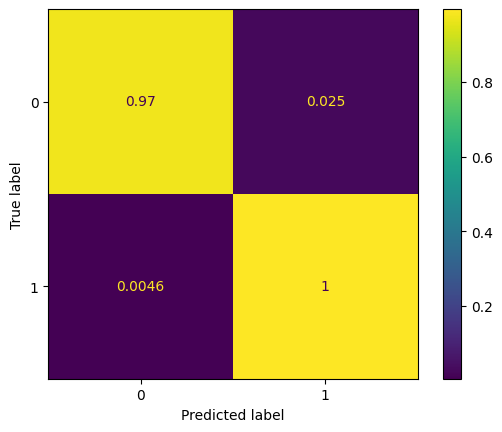

In [115]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

# Show the sizes of the training and test sets
print("Training set has {} samples.".format(X_train.shape[0]))
print("Test set has {} samples.".format(X_test.shape[0]))

# Show the balance of labels in the training and test sets
print("Training set has {} malware samples.".format(sum(y_train)))
print("Training set has {} legitimate samples.".format(len(y_train) - sum(y_train)))


# Instantiate model 
model = RandomForestClassifier(n_estimators = 50)

scores = cross_val_score(model, X_train, y_train, cv=5)
print("Cross validation scores:", scores)
print("Average cross validation score:", np.mean(scores))

model.fit(X_train, y_train)

# Accuracy on training set
score = model.score(X_train, y_train)
print("Accuracy on training:", score)

# Show accuracy score
score = model.score(X_test, y_test)
print("Accuracy on test:", score)

# Show AUC score
print("AUC:", roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))

# Show the F1 score
from sklearn.metrics import f1_score
print("F1 score:", f1_score(y_test, model.predict(X_test)))

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
print("Ten most important features")
for f in range(min(10, X_train.shape[1])):
    print("%d. feature %s (%f)" % (f + 1, features_names[indices[f]], importances[indices[f]]))

print(confusion_matrix(y_test, model.predict(X_test)))

# Plot the confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, normalize='true')
plt.show()

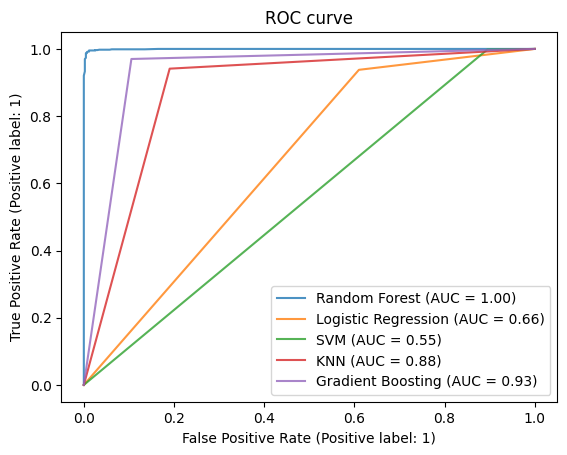

In [129]:
from sklearn.metrics import RocCurveDisplay
from sklearn.linear_model import LogisticRegression

ax = plt.gca()
roc_curve = RocCurveDisplay.from_estimator(model, X_test, y_test, ax=ax, name='Random Forest', alpha=0.8)


lr_model = LogisticRegression(max_iter=10000)
lr_model.fit(X_train, y_train)
y_test_lr_predict = lr_model.predict(X_test)
lr_disp = RocCurveDisplay.from_predictions(y_test, y_test_lr_predict, name='Logistic Regression', ax=ax, alpha=0.8)

from sklearn.svm import SVC
svc = SVC(random_state=42)
svc.fit(X_train, y_train)
y_test_svm_predict = svc.predict(X_test)
svm_disp = RocCurveDisplay.from_predictions(y_test, y_test_svm_predict, name='SVM', ax=ax, alpha=0.8)

from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train)
y_test_knn_predict = neigh.predict(X_test)
knn_disp = RocCurveDisplay.from_predictions(y_test, y_test_knn_predict, name='KNN', ax=ax, alpha=0.8)

from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators=30, learning_rate=1.0,
    max_depth=1, random_state=0).fit(X_train, y_train)
y_test_gb_predict = clf.predict(X_test)
gd_disp = RocCurveDisplay.from_predictions(y_test, y_test_gb_predict, name='Gradient Boosting', ax=ax, alpha=0.8)
plt.title('ROC curve');

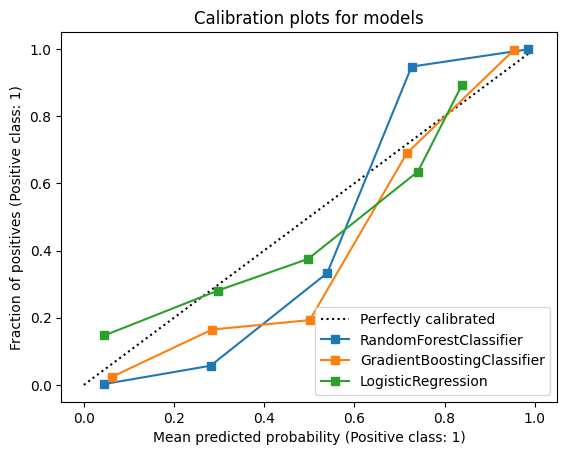

In [130]:
from sklearn.calibration import CalibrationDisplay

ax= plt.gca()
n_bins = 5
disp = CalibrationDisplay.from_estimator(model, X_test, y_test, ax=ax, n_bins=n_bins)
disp = CalibrationDisplay.from_estimator(clf, X_test, y_test, ax=ax, n_bins=n_bins)
disp = CalibrationDisplay.from_estimator(lr_model, X_test, y_test, ax=ax, n_bins=n_bins)
plt.title("Calibration plots for models");

/Users/khannay/miniconda3/envs/malware-detect/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/khannay/miniconda3/envs/malware-detect/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


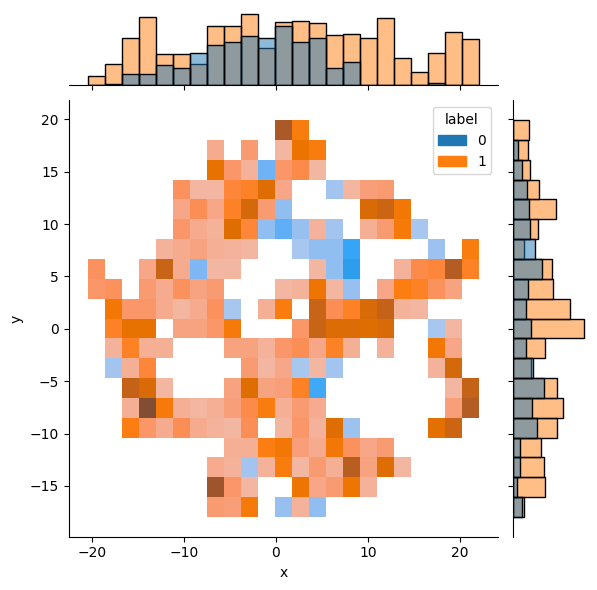

In [140]:
# Create an tsne embedding of the data and show the labels from y_train 


import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
TSNE_model = TSNE(n_components=3)
X_embedded = TSNE_model.fit_transform(X_train)

df_tsne = pd.DataFrame({ 'x': X_embedded[:,0], 'y': X_embedded[:,1], 'z': X_embedded[:,2], 'label': y_train })
sns.jointplot(data=df_tsne, x="x", y="y", hue="label", kind="hist");


# Create an tsne embedding of the data and show the labels from y_train", hue="species", kind="kde")

In [118]:

TPATH = DATA_PATH / 'test/malware'
test_files = list(TPATH.glob('**/*.pcap'))
Xt = np.vstack([collect_flow_stats(f) for f in test_files])
y_test2 = np.ones(Xt.shape[0])
accuracy = 1.0 - np.abs(model.predict(Xt) - y_test2).sum() / Xt.shape[0]
print(f"Accuracy on test set for malware: {accuracy:.2f}")


Accuracy on test set for malware: 1.00


In [119]:
TPATH = DATA_PATH / 'test/benign'
test_files = list(TPATH.glob('**/*.pcap'))
Xt = np.vstack([collect_flow_stats(f) for f in test_files])
y_test2 = np.zeros(Xt.shape[0])
accuracy = 1.0 - np.abs(model.predict(Xt) - y_test2).sum() / Xt.shape[0]
print(f"Accuracy on test set for benign traffic: {accuracy:.2f}")

Accuracy on test set for benign traffic: 0.95


## TODO List

* Clean this code up and create a proper package, adding comments and an actual flow. Explain the feature engineering components, model training and evaluation.
* MLOps: How to use elastic and a model, and feature registry, and model deployment.
* Dockerize the project 
* Add a detailed README.md to the project explaining the project and how to use it.
* Create an arch diagram for a elastic deployment. 

In [38]:
#| hide

import nbdev; nbdev.nbdev_export()